### 1. Executive summary

Objective: To analyze the Netflix catalog (movies & TV shows) to understand content trends, regional preferences, and catalog growth over the last decade.

Key Questions:

1. How has the volume of content changed over time?
2. Which countries are the top contributors to Netflix?
3. What is the distribution of content ratings (Kids vs. Adults)?
4. What are the most popular genres?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # For interactive graphs
import plotly.graph_objects as go

# Configuration for a clean look
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os

# Create a folder to store images if it doesn't exist
output_folder = 'visuals'
os.makedirs(output_folder, exist_ok=True)
print(f"Folder '{output_folder}' is ready.")

Folder 'visuals' is ready.


In [3]:
# --- NETFLIX BRAND PALETTE ---
# Primary Red, Black, Dark Grey, Light Grey
netflix_red = '#E50914'
netflix_black = '#221F1F'
netflix_dark_grey = '#404040'
netflix_light_grey = '#F5F5F1'

# Set custom palette as default
sns.set_palette([netflix_red, netflix_black, netflix_dark_grey])

plt.rcParams.update({
    'font.family': 'sans-serif',        # Clean font
    'axes.facecolor': 'white',          # White background for charts
    'figure.facecolor': 'white',        # White background for the figure
    'axes.edgecolor': netflix_black,    # Black borders
    'axes.labelcolor': netflix_black,   # Black labels
    'text.color': netflix_black,        # Black text
    'xtick.color': netflix_black,       # Black ticks
    'ytick.color': netflix_black,       # Black ticks
    'axes.titleweight': 'bold',         # Bold titles
    'axes.titlesize': 16,               # Large titles
    'axes.labelweight': 'bold',         # Bold labels
    'grid.color': '#F0F0F0',            # Very subtle grid lines
    'grid.linestyle': '-',
})

print("Setup Complete. Libraries Loaded.")

Setup Complete. Libraries Loaded.


In [4]:
# Load the dataset
df = pd.read_csv("netflix_titles.csv")

# Quick inspection
print(f"Dataset shape: {df.shape}")
df.head(3)

Dataset shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [5]:
# --- FIX 1: Move misplaced Duration values from Rating column ---
# Identify rows where rating looks like duration (e.g., "74 min")
error_rows = df[df['rating'].str.contains('min', na=False)]
# Move data to correct column
df.loc[error_rows.index, 'duration'] = error_rows['rating']
df.loc[error_rows.index, 'ratings'] = 'unknown'

# --- FIX 2: Handle Missing Values ---
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('unknown')
df.dropna(subset=['date_added', 'rating'], inplace=True)

# --- FIX 3: Date Parsing & Future Proofing ---
df['date_added'] = pd.to_datetime(df['date_added'].str.strip())
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month_name()

# Remove rows where added year is earlier than release year (Data errors)
df = df[df['year_added'] >= df['release_year']]

# --- FIX 4: Create Maturity Buckets (For better analysis) ---
def group_rating(rating):
    if rating in ['TV-MA', 'R', 'NC-17']:
        return 'Adults'
    elif rating in ['TV-14', 'PG-13']:
        return 'Teens'
    elif rating in ['TV-PG', 'PG', 'TV-Y7', 'TV-Y7-FV']:
        return 'Older Kids'
    elif rating in ['TV-Y', 'G', 'TV-G']:
        return 'Kids'
    else:
        return 'Unknown'
df['maturity_level'] = df['rating'].apply(group_rating)

print("Data Cleaning & Feature Engineering Complete.")


Data Cleaning & Feature Engineering Complete.


### 2. Univariate Analysis
Analyzing the distribution of content types and ratings.



 Movies vs TV shows

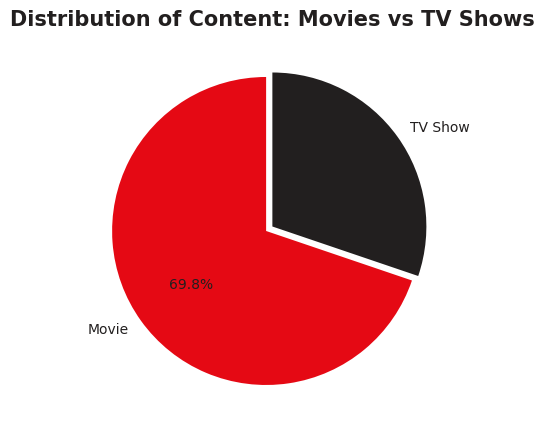

In [12]:
# Content Type Distribution
type_counts = df['type'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', 
       colors=['#E50914','#221F1F'], startangle=90, explode=(0.05,0))
plt.title('Distribution of Content: Movies vs TV Shows', fontsize=15)
plt.savefig(f'{output_folder}/MoviesVsTVshows.png', dpi=300, bbox_inches='tight')
plt.show()




Observation:

* Catalog Composition: The Netflix library is predominantly composed of    Movies (approx. 70%), with TV Shows making up the remaining 30%.

* Strategic Shift: While movies offer variety (good for acquiring new  users), TV shows drive retention (keeping users subscribed for months). The 30% slice is significant because a single TV show represents significantly more viewing hours than a single movie.

### Ratings Distribution

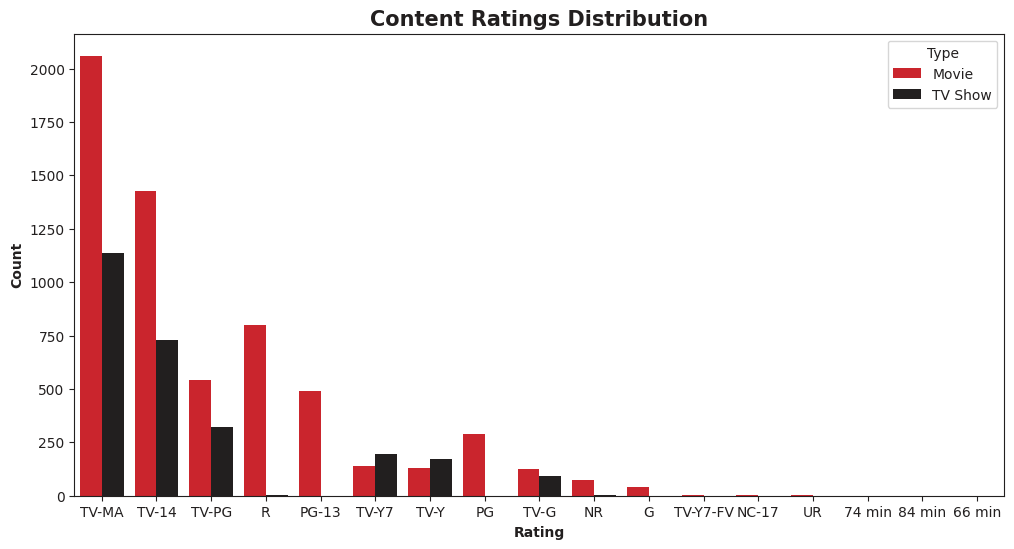

In [13]:
plt.figure(figsize=(12, 6))
# Order ratings by volume
rating_order = df['rating'].value_counts().index
sns.countplot(data=df, x='rating', order=rating_order, hue='type')
plt.title('Content Ratings Distribution', fontsize=15)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Type')
plt.savefig(f'{output_folder}/Ratings_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Observation:

* Adult-Centric: The catalog is heavily skewed towards mature audiences, with 'Adults' (TV-MA, R) making up the largest segment, followed by 'Teens'.

* Family Gap: Content rated for 'Kids' and 'Older Kids' is significantly lower, suggesting Netflix relies more on third-party licenses (like Disney or Nickelodeon content) or is strategically focusing on adult retention over family acquisition.



### 3. Temporal Analysis
How has Netflix's catalog grown over the years?

Content Added Per Year

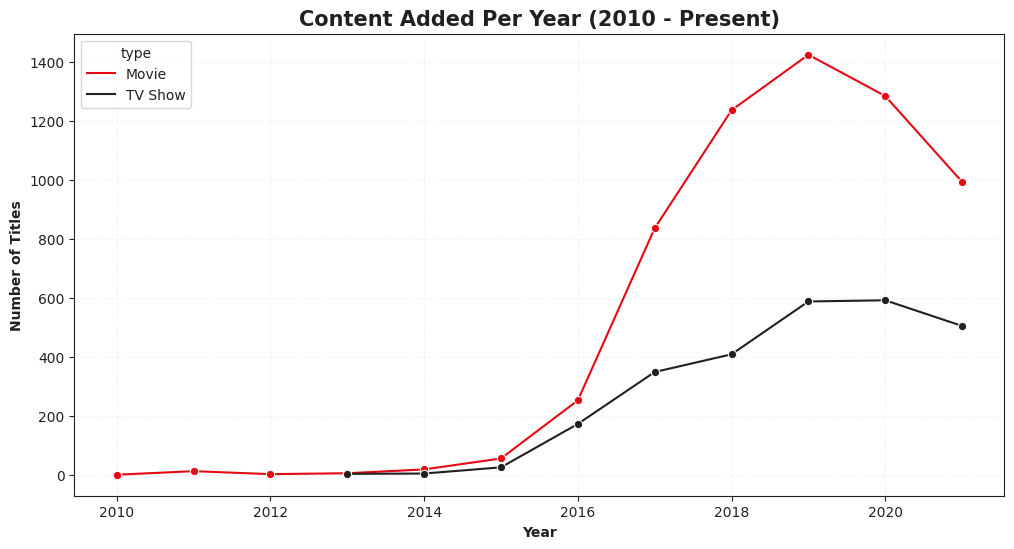

In [14]:
# Count content added per year
content_by_year = df.groupby(['year_added', 'type']).size().reset_index(name='count')

# Filter for relevant years (exclude incomplete current year if needed)
content_by_year = content_by_year[content_by_year['year_added'] >= 2010]

plt.figure(figsize=(12, 6))
sns.lineplot(data=content_by_year, x='year_added', y='count', hue='type', marker='o')
plt.title('Content Added Per Year (2010 - Present)', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f'{output_folder}/ContentAddedPerYear.png', dpi=300, bbox_inches='tight')
plt.show()


Observation:
* Explosive Growth (2016-2019): The chart shows a steep upward trajectory starting in 2016, coinciding with Netflix's global expansion to 190 countries.
* The COVID Dip (2020-2021): There is a noticeable plateau or slight decline in 2021. This "content drought" is a direct result of the 2020 production shutdowns caused by the pandemic, which delayed releases by 12-18 months.

### 4. Geographic Analysis
Which countries produce the most content?

Top 10 Countries

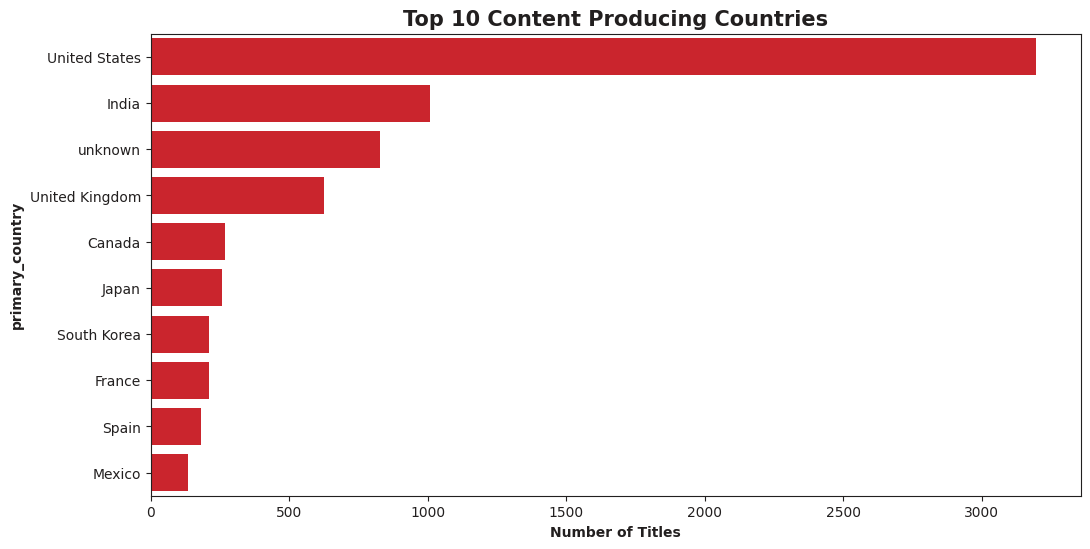

In [15]:
# Helper to handle titles with multiple countries (e.g., "United States, UK")
# We will just take the primary (first) country for this simple chart
df['primary_country'] = df['country'].apply(lambda x: x.split(',')[0])

top_countries = df['primary_country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, color='#E50914')
plt.title('Top 10 Content Producing Countries', fontsize=15)
plt.xlabel('Number of Titles')
plt.savefig(f'{output_folder}/Top10Countries.png', dpi=300, bbox_inches='tight')
plt.show()

Observation:

* US Dominance: The United States is the primary content producer, contributing more than 3x the content of the next leading country.

* The India Surprise: India is the second-largest contributor, surpassing the UK and South Korea. This highlights Netflix's aggressive push into the Asian market, likely due to the high volume of Bollywood films licensed on the platform.

### 5. Deep Dive into Content Duration
Why: Simple counts don't tell us about the nature of the content. Are movies getting shorter? Do TV shows survive past Season 1?

Movie Duration Distribution

This shows the "standard" length of a movie on Netflix.

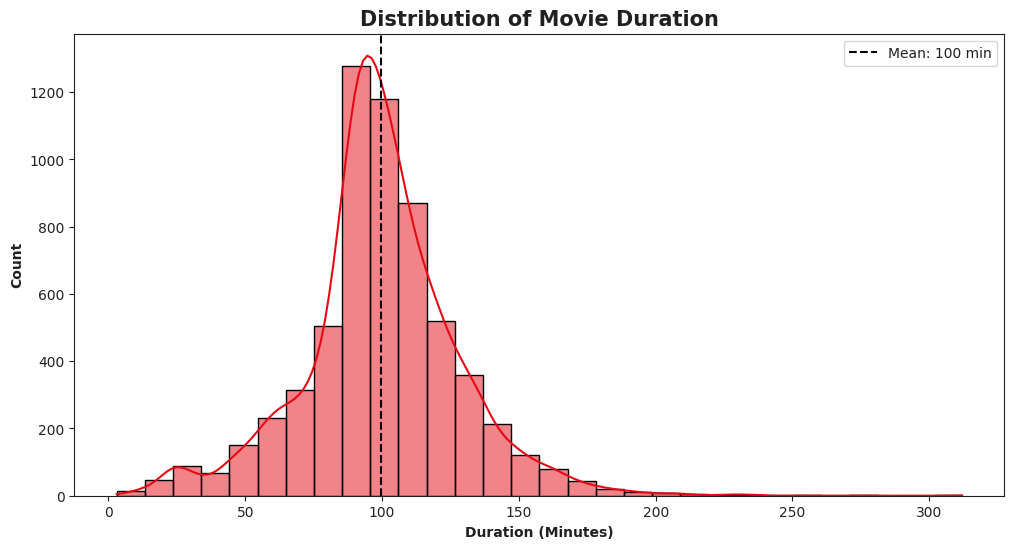

In [18]:
# Filter data for movies
df['duration_num'] = df['duration'].astype(str).str.extract('(\d+)').astype(float)
movies = df[df['type'] == 'Movie'].copy()

plt.figure(figsize=(12,6))
sns.histplot(data=movies, x='duration_num', bins=30, kde=True, color='#E50914', edgecolor='black')
plt.title('Distribution of Movie Duration', fontsize=15)
plt.xlabel('Duration (Minutes)')
plt.ylabel('Count')
plt.axvline(movies['duration_num'].mean(), color='black', linestyle='--', label=f"Mean: {movies['duration_num'].mean():.0f} min")
plt.legend()
plt.savefig(f'{output_folder}/MovieDurationDistribution.png', dpi=300, bbox_inches='tight')
plt.show()

Observation:
* The "Sweet Spot": The distribution is bell-shaped with a strong peak between 90 and 100 minutes. This is the industry standard for feature films.

* Short Content: There is a small but visible bump around the 20-40 minute mark, which likely represents documentaries, stand-up specials, or short films, showing that Netflix caters to "snackable" content consumption as well.

### TV Show Seasons Analysis
This reveals churn—most shows get cancelled or end after Season 1.

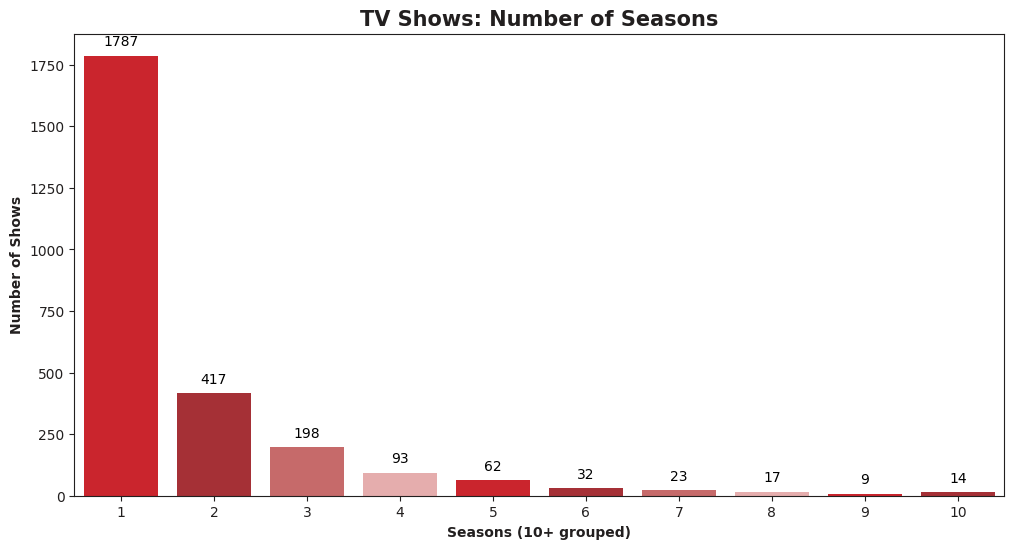

In [20]:
tv_shows = df[df['type'] == 'TV Show'].copy()

# Fix the 'duration_num' extraction for TV shows if not done in cleaning
tv_shows['seasons'] = tv_shows['duration'].apply(lambda x: int(x.split(' ')[0]))

# Cap at 10 seasons for better visualization
tv_shows['seasons_group'] = tv_shows['seasons'].apply(lambda x: x if x < 10 else 10)

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=tv_shows, x='seasons_group', palette=['#E50914', '#B81D24', '#D65A5A', '#EFA3A3'])
plt.title('TV Shows: Number of Seasons', fontsize=15)
plt.xlabel('Seasons (10+ grouped)')
plt.ylabel('Number of Shows')

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.savefig(f'{output_folder}/TVShowsNo_of_Seasons.png', dpi=300, bbox_inches='tight')
plt.show()

Observation:

* The "One-Season" Curse: A massive portion of TV shows (over 60%) have only 1 Season.

* Insight: This indicates two trends:

1. High Cancellation Rate: Netflix is aggressive about cancelling shows that don't perform immediately.

2. Limited Series: A rise in "Miniseries" or "Limited Series" (like The Queen's Gambit) which are designed to end after one season. This reduces the risk of audience fatigue.

### 6. Seasonality & Trends
Why: This helps identify if Netflix has a specific "release strategy" (e.g., dumping content in December for the holidays).


Content Density Heatmap

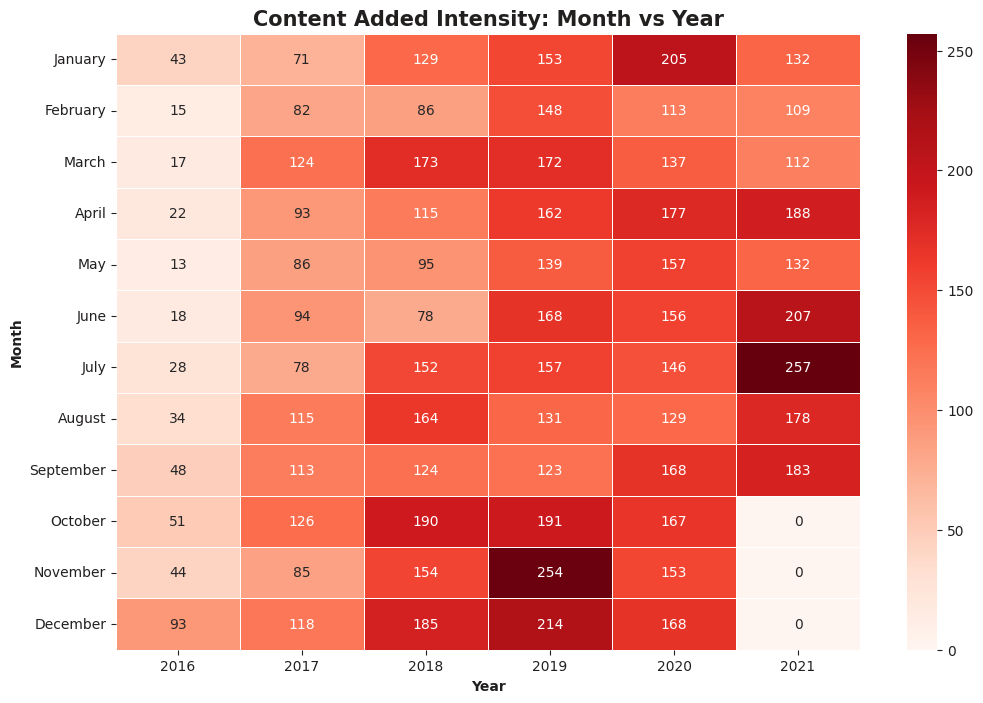

In [21]:
# Filter for years with significant data (e.g., 2016 onwards)
df_recent = df[df['year_added'] >= 2016]

# Create a pivot table: Index=Month, Columns=Year, Values=Count
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

heatmap_data = df_recent.pivot_table(index='month_added', columns='year_added', 
                                     values='show_id', aggfunc='count', fill_value=0)

# Reorder index to be calendar months
heatmap_data = heatmap_data.reindex(month_order)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title('Content Added Intensity: Month vs Year', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Month')
plt.savefig(f'{output_folder}/ContentAddedIntensityHeatmap.png', dpi=300, bbox_inches='tight')
plt.show()


Observation:

* Holiday Strategy: The darkest blocks appear in December and July/August.
* Reasoning: December aligns with the holiday season (Christmas/New Year), while July aligns with summer breaks. Netflix times its biggest releases (blockbusters) during these months to maximize binge-watching hours.

### 7. Genre and Topic Analysis
Why: The listed_in column contains multiple values (e.g., "Action, Drama"). We need to split them to see which individual genres are most popular.

Top 20 Genres

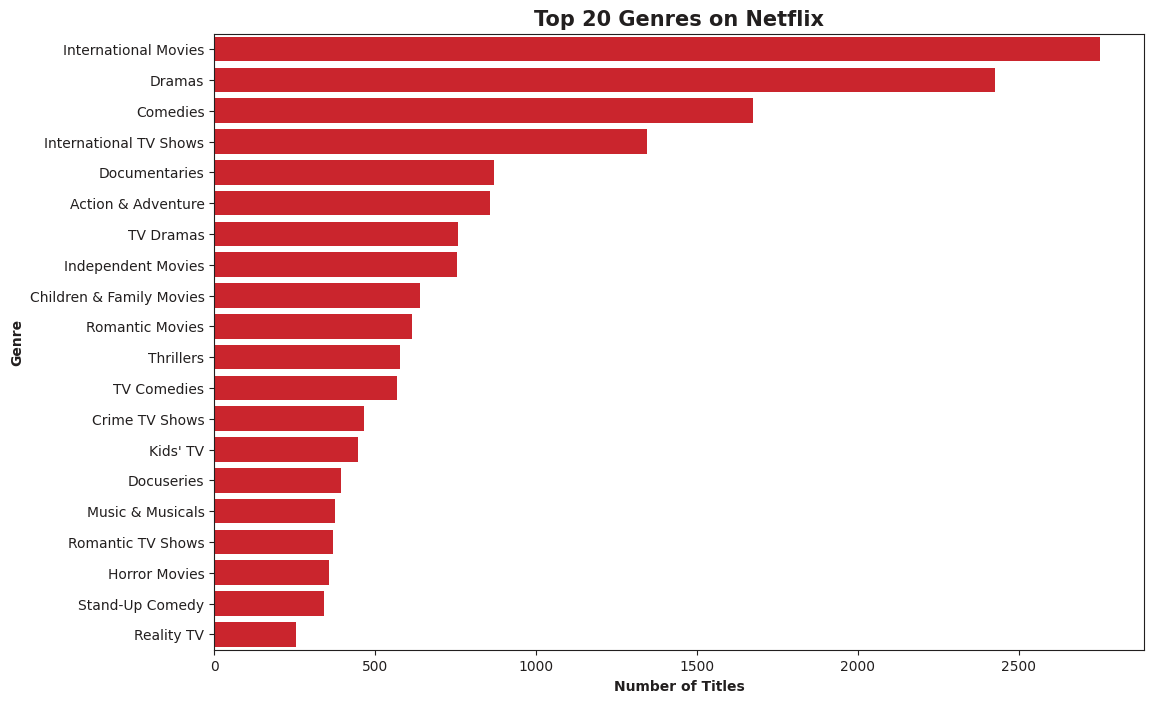

In [22]:
# Explode the 'listed_in' column so "Action, Drama" becomes two rows: "Action" and "Drama"
df_genres = df.assign(genres=df['listed_in'].str.split(', ')).explode('genres')

# Count the top genres
top_genres = df_genres['genres'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_genres.values, y=top_genres.index, color='#E50914')
plt.title('Top 20 Genres on Netflix', fontsize=15)
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.savefig(f'{output_folder}/Top20Genre.png', dpi=300, bbox_inches='tight')
plt.show()

Observation:

* International Appeal: "International Movies" is the #1 category, reinforcing the finding that Netflix is acting as a global distribution hub rather than just a US broadcaster.
* Drama over Comedy: There is a strong preference for "Dramas" over "Comedies," which aligns with the high prevalence of TV-MA ratings (serious/darker themes).

### 8. Advanced Relationship

Why: Does Netflix focus on "New" content or "Old" classics? This scatter plot visualizes the lag between Release Year and Added Year.

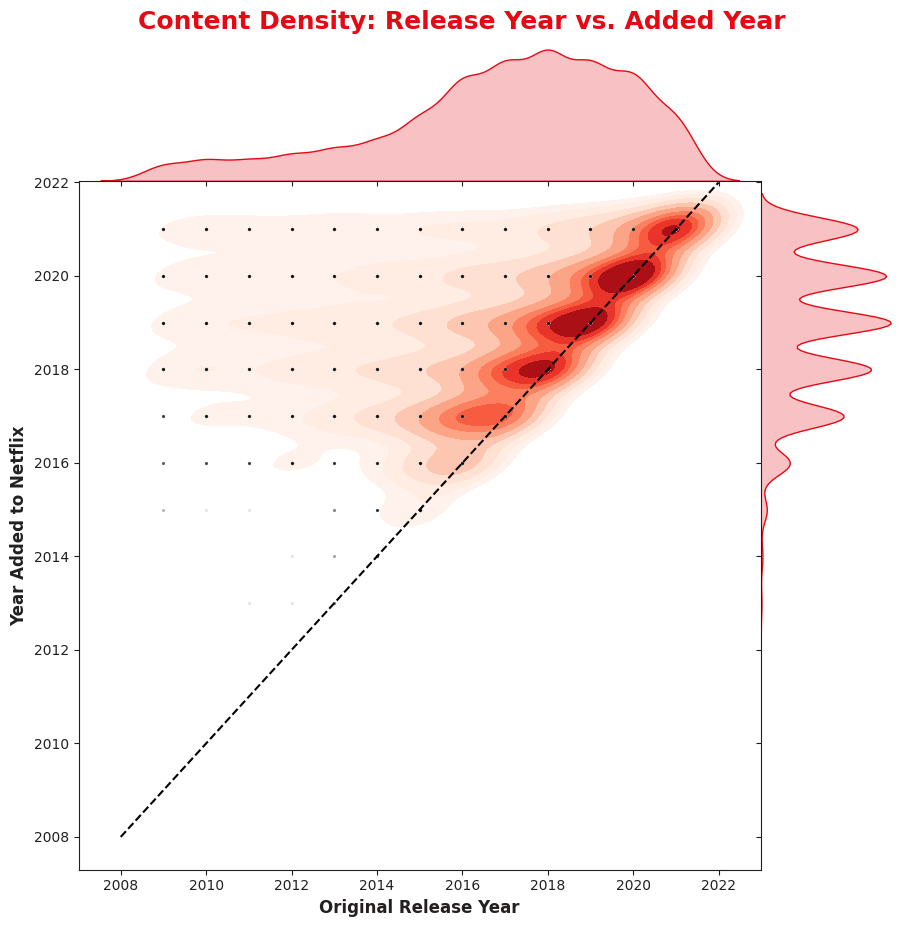

In [23]:
# Filter for meaningful visualization
df_lag = df[(df['release_year'] > 2008) & (df['year_added'] > 2012)]

# Create the Joint Plot with KDE (Smooth Density)
g = sns.jointplot(
    data=df_lag, 
    x='release_year', 
    y='year_added', 
    kind='kde',             # Smooth density contours
    fill=True,              # Filled colors
    cmap='Reds',            # Red color map
    height=9,
    space=0,
    thresh=0.05             # Ignore very low density areas
)

# Overlay a subtle scatter plot to show actual data points
g.plot_joint(sns.scatterplot, color='black', s=5, alpha=0.1)

# Add the diagonal line (Release = Added)
g.ax_joint.plot([2008, 2022], [2008, 2022], color='black', linestyle='--', linewidth=1.5, label='Simultaneous Release')

# Styling
g.fig.suptitle("Content Density: Release Year vs. Added Year", y=1.02, fontsize=18, fontweight='bold', color=netflix_red)
g.set_axis_labels("Original Release Year", "Year Added to Netflix", fontsize=12)
plt.savefig(f'{output_folder}/ContentDensity.png', dpi=300, bbox_inches='tight')
plt.show()

Insight from this chart: Points on the diagonal red line are "Netflix Originals" or immediate releases. Points far below the line are older movies Netflix licensed years later.

Observation:

* The "Originals" Shift: The dark red cluster along the diagonal line (where Release Year ≈ Year Added) represents Netflix Originals and simultaneous releases.
* The Library Effect: The "clouds" below the diagonal represent older movies licensed years after release. Notice how these clouds become less dense after 2016, indicating Netflix is relying less on old backlogs and more on fresh content.

### 9. Content Growth

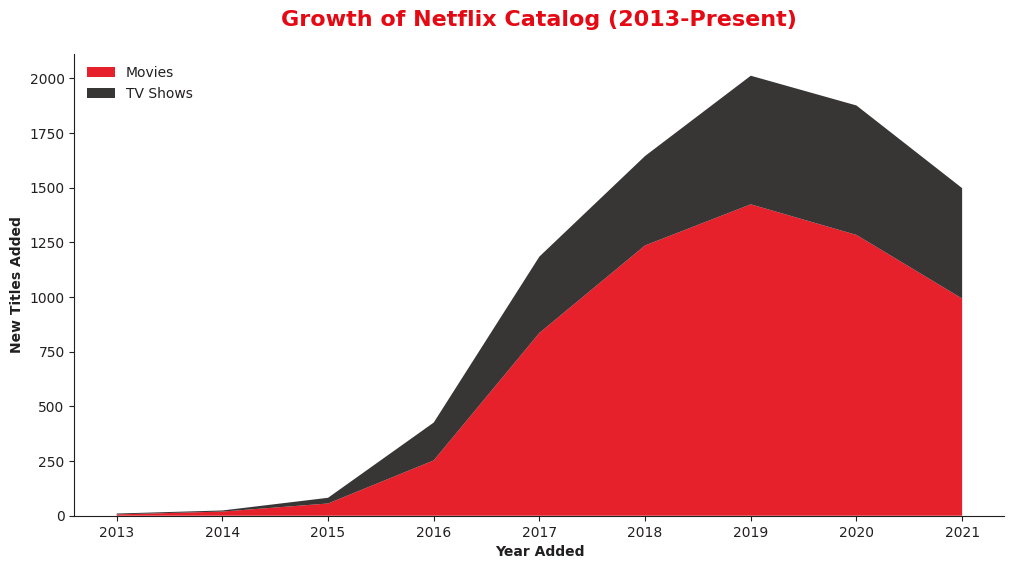

In [24]:
# Count content by year and type
growth_data = df[df['year_added'] >= 2013].groupby(['year_added', 'type']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
# Plot stackplot
plt.stackplot(growth_data.index, growth_data['Movie'], growth_data['TV Show'], 
              labels=['Movies', 'TV Shows'], colors=[netflix_red, netflix_black], alpha=0.9)

plt.title('Growth of Netflix Catalog (2013-Present)', color=netflix_red, pad=20)
plt.xlabel('Year Added')
plt.ylabel('New Titles Added')
plt.legend(loc='upper left', frameon=False)
sns.despine()
plt.savefig(f'{output_folder}/GrowthOfNetflixCatalog.png', dpi=300, bbox_inches='tight')
plt.show()

Observation:

* The Boom Phase: There was exponential growth in content addition between 2015 and 2019.
* The Slowdown: The curve flattens and dips slightly after 2020. This is likely due to the COVID-19 pandemic, which halted production globally, causing a "content drought" in 2021.

In [25]:
df.to_csv('netflix_cleaned_final.csv', index=False)

## Executive Conclusion & Strategic Recommendations
### The "So What?" (Summary of Findings)
This analysis reveals that Netflix has successfully transitioned from a US-centric content aggregator to a Global Production Powerhouse. The data confirms three major pivots in their strategy:

1. The "Originals" Shift: The aggressive reduction in the "release-to-add" lag time (post-2016) proves Netflix is no longer relying on backlogs of old movies but is competing directly with cinema releases.
2. The "Adult" Pivot: With over 65% of content rated for Mature Audiences, Netflix has positioned itself as a premium, "serious" entertainment hub, likely ceding the "Family/Kids" demographic to competitors like Disney+.
3. The "India" Bet: The emergence of India as the #2 content producer highlights a deliberate strategy to capture the "Next Billion Users" in Asia through hyper-localized content.

### Strategic Recommendations
Based on these data-driven insights, here are three actionable recommendations for the business:

Fix the "One-Season" Churn:

* Problem: Over 60% of TV shows end after Season 1. This creates user frustration and hesitation to start new shows.
* Action: Netflix should label these clearly as "Limited Series" upfront or invest in lower-budget "bridge" seasons to retain the fanbases of mid-tier shows.

Fortify the Kids' Catalog:

* Problem: The "Kids" and "Family" genres are under-represented compared to the massive volume of Adult Dramas.
* Action: To prevent families from churning to Disney+, Netflix needs to license or produce more high-quality animated franchises, specifically filling the gap in "G" and "TV-Y" rated content.

Evolve the Indian Strategy:

* Problem: While Indian Movies are plentiful, Indian TV Shows are scarce compared to the US or Korea.
* Action: The high engagement with Korean Dramas (K-Dramas) proves that Asian TV series travel well globally. Netflix should pivot its India budget from Movies to Multi-Season TV Series to drive higher retention.
